Group 30_Neural Network project

This noteboos compares the use of three models (VG16, MobileNet and a Generic Convolutional network in image classification

In [1]:
# Install visualkeras to enable us visualize the network in 3D
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.0 MB/s eta 0:00:00


In [2]:
# Core TensorFlow library for machine learning and neural network models.
import tensorflow as tf
# For our first Model, VGG16 model from Keras applications for deep learning models pre-trained on ImageNet dataset.
from tensorflow.keras.applications import VGG16
# Utilities for preprocessing images and decoding predictions.
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
# For our Second Model, Load MobileNet model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#For our third model, The ConvGen(Convolutional Generic) model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# OS module for operating system interactions, such as file path management.
import os
# PIL (Python Imaging Library) for image processing tasks.
import PIL
# Importing components from Keras for building and training models.
from tensorflow.keras import datasets, layers, models
# Utility to visualize the architecture of neural networks.
from keras.utils import plot_model
# Matplotlib for plotting, e.g., displaying images and graphs.
import matplotlib.pyplot as plt
# NumPy for numerical computing and handling large, multi-dimensional arrays and matrices.
import numpy as np
# Sklearn for evaluating our model
from sklearn.metrics import confusion_matrix
# import visualkeras
import visualkeras

In [3]:
# Import the drive module from the google.colab package.
from google.colab import drive

# Mount the Google Drive to the specified mount point in the Colab environment.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_directory = "/content/drive/MyDrive/image_classification"
train_directory = os.path.join(data_directory, "seg_train", "seg_train")
test_directory = os.path.join(data_directory, "seg_test", "seg_test")
image_size = (128, 128)  # Adjust this tuple according to your requirements

In [5]:
# Check the contents og the directories
print("Contents of seg_train:")
print(os.listdir('/content/drive/MyDrive/image_classification/seg_train'))

print("Contents of a category within seg_train:")
first_category = os.listdir('/content/drive/MyDrive/image_classification/seg_train')[0]
print(os.listdir(os.path.join('/content/drive/MyDrive/image_classification/seg_train', first_category)))


Contents of seg_train:
['seg_train']
Contents of a category within seg_train:
['glacier', 'mountain', 'sea', 'street', 'forest', 'buildings']


In [6]:
# Function to load and preprocess data from a given directory.
def load_and_preprocess_data(directory, image_size):
    data = []  # Initialize a list to store image data
    labels = []  # Initialize a list to store image labels
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)  # Get the full path to the category folder
        if not os.path.isdir(category_folder):  # Skip if not a directory
            continue
        label = category  # Use the folder name as the label for all images in this folder
        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)  # Get the full path to the image
            if not os.path.isfile(image_path) or not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            # Load and preprocess the image
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            # Convert the image to a numpy array and normalize it
            image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
            data.append(image_array)  # Append the processed image data to the data list
            labels.append(label)  # Append the label to the labels list
    return np.array(data), np.array(labels)  # Convert the lists to numpy arrays for further processing in TensorFlow

# Load Train and Test data
train_images, train_labels = load_and_preprocess_data(train_directory, image_size)
test_images, test_labels = load_and_preprocess_data(test_directory, image_size)

print(train_images)

[[[[0.04313726 0.10588235 0.20392157]
   [0.04705882 0.10980392 0.20784314]
   [0.04705882 0.10980392 0.20784314]
   ...
   [0.05098039 0.03137255 0.01960784]
   [0.07058824 0.05098039 0.03921569]
   [0.2901961  0.27058825 0.25882354]]

  [[0.03921569 0.10196079 0.2       ]
   [0.04313726 0.10588235 0.20392157]
   [0.04313726 0.10588235 0.20392157]
   ...
   [0.06666667 0.05098039 0.03921569]
   [0.01568628 0.         0.        ]
   [0.25490198 0.23921569 0.22745098]]

  [[0.04705882 0.10980392 0.2       ]
   [0.05098039 0.11372549 0.20392157]
   [0.05098039 0.11372549 0.20392157]
   ...
   [0.03529412 0.03137255 0.02352941]
   [0.04705882 0.03137255 0.02745098]
   [0.1764706  0.17254902 0.16470589]]

  ...

  [[0.18431373 0.16470589 0.14901961]
   [0.23529412 0.21568628 0.2       ]
   [0.16470589 0.14509805 0.13333334]
   ...
   [0.11372549 0.10980392 0.10196079]
   [0.17254902 0.16862746 0.16078432]
   [0.19215687 0.1882353  0.18039216]]

  [[0.20392157 0.18431373 0.17254902]
   [0.2

In [7]:
# Print the shape of the data and labels arrays
print("Data shape:", train_images.shape)
print("Labels shape:", train_labels.shape)

Data shape: (14044, 128, 128, 3)
Labels shape: (14044,)


In [8]:
# Distribution of Data points among classes
import pandas as pd
freq = pd.Series(train_labels).value_counts()
print(freq)

mountain     2512
glacier      2414
street       2382
sea          2274
forest       2271
buildings    2191
dtype: int64


In [9]:
#  Print list of unique labels, class_names
class_names = unique_labels = np.unique(train_labels)
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [10]:
class_to_index = {name: index for index, name in enumerate(class_names)}
index_to_class = {index: name for name, index in class_to_index.items()}

train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


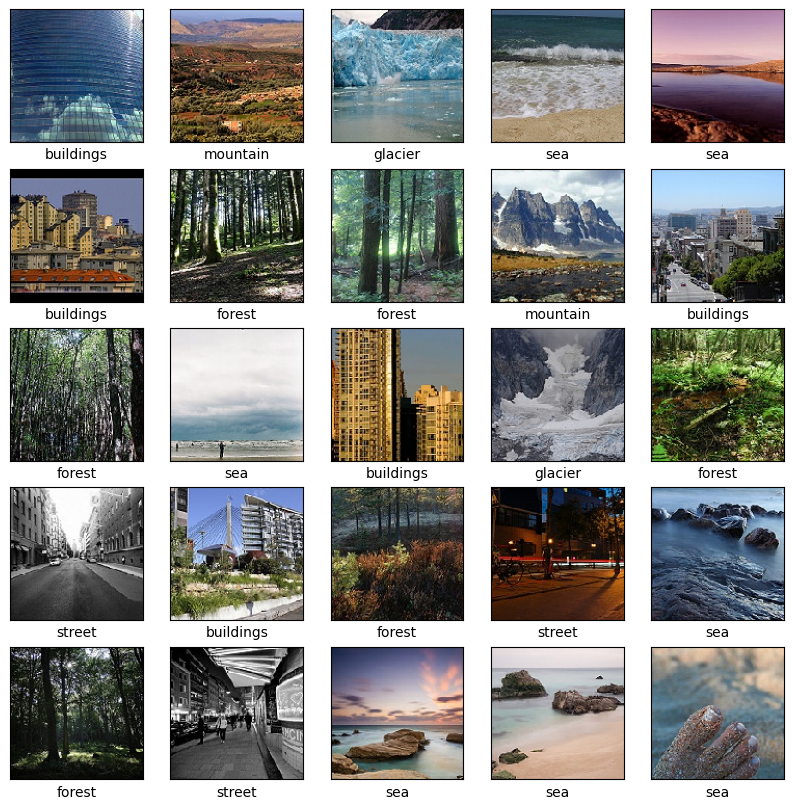

In [11]:
label_to_index = {label: index for index, label in enumerate(class_names)}

# Select 25 random image indices
random_indices = np.random.choice(len(train_images), size=25, replace=False)

plt.figure(figsize=(10,10))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_index])  # Use the random_index here
    label_index = label_to_index[train_labels[random_index]]  # And here
    plt.xlabel(class_names[label_index])
plt.show()


####Load the Model 1- VGG16

In [12]:
# Load the VGG16 model pre-trained weights on ImageNet dataset.
# input_shape=(128, 128, 3)
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Iterate through each layer in the base model.
for layer in VGG_model.layers:
        layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


### Load the Model 2 Mobile Net

In [13]:
# Load MobileNet model
MNet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in MNet_model.layers:
    layer.trainable = False

# Adding custom layers on top of MobileNet
MNet_model = Sequential([
    MNet_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

17225924/17225924 [==============================] - 0s 0us/step


###Initiate Model 3 Conv_Gen(Convolutional Generic) from the scratch

In [14]:
Conv_Gen_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

Conv_Gen_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Iterate through each layer in the model.
for layer in Conv_Gen_model.layers:
        layer.trainable = False

###Visualize the 3 models

In [15]:
import visualkeras

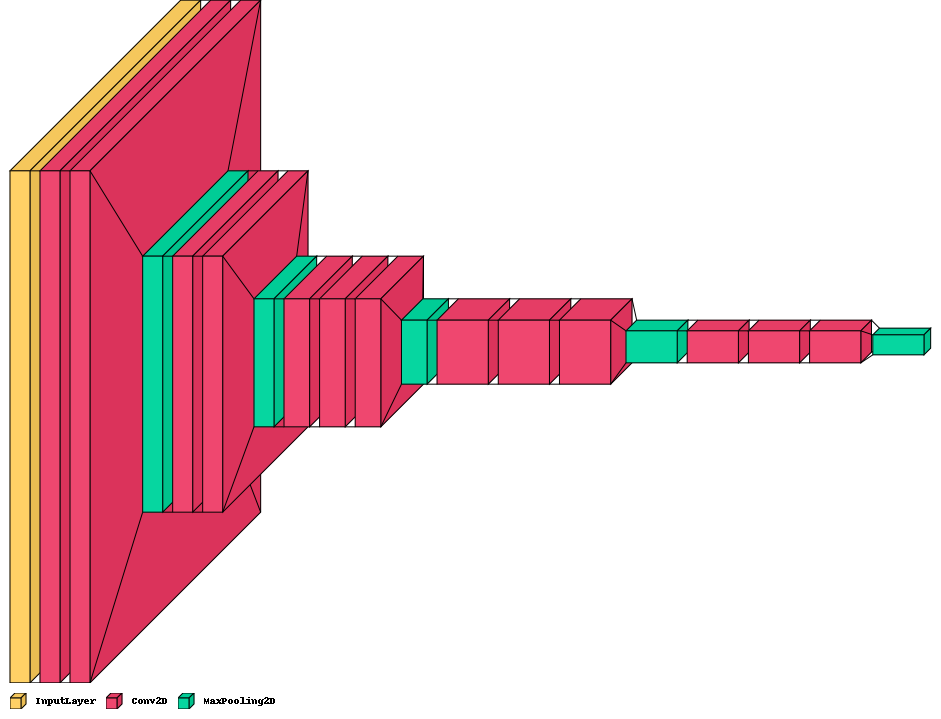

In [16]:
# Let's visualize the 3 models
# visualize the VGG
visualkeras.layered_view(VGG_model,legend=True)

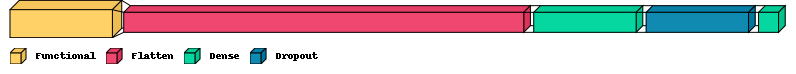

In [17]:
# visualise the Mobile_Net
visualkeras.layered_view(MNet_model,legend=True)

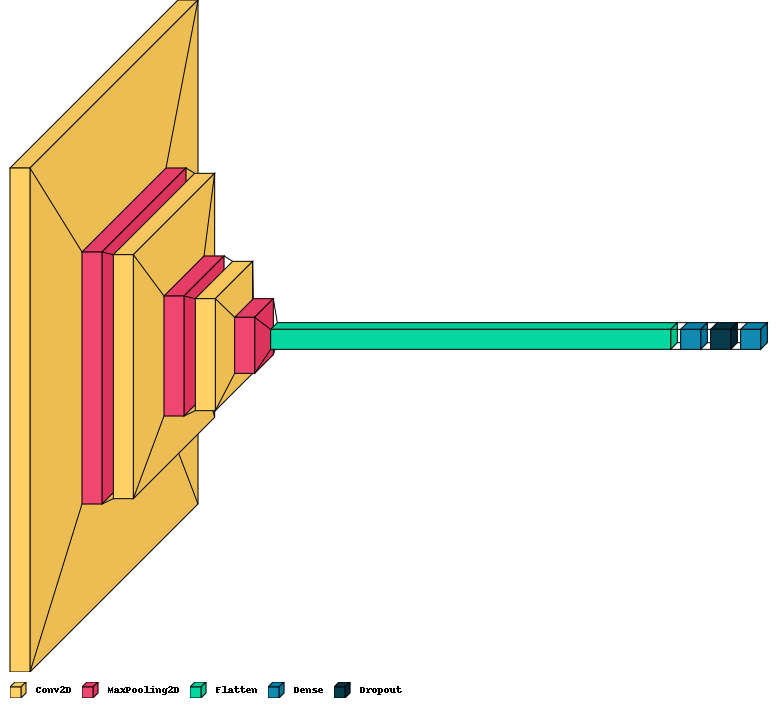

In [18]:
#visualise the generic model, Conv_Gen
# Let's visualize the model
visualkeras.layered_view(Conv_Gen_model,legend=True)

####Plot the 3 models

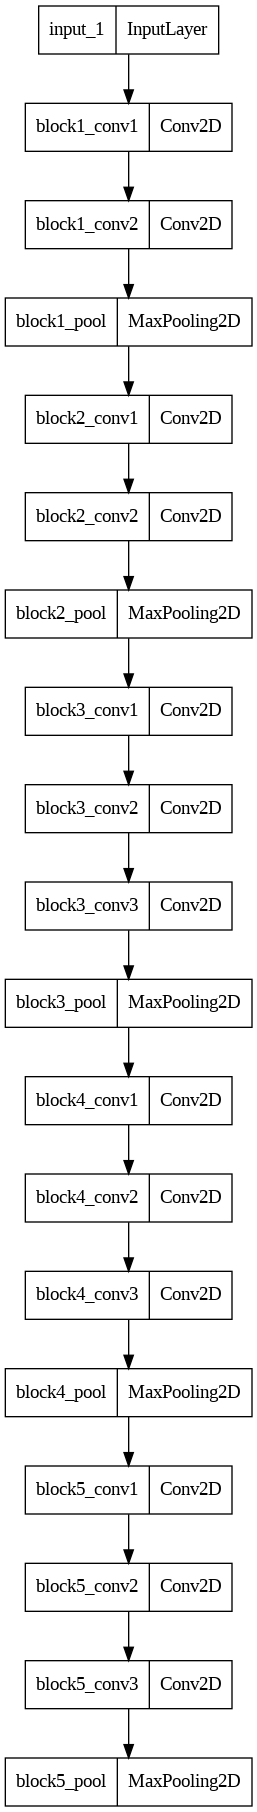

In [19]:
plot_model(VGG_model)

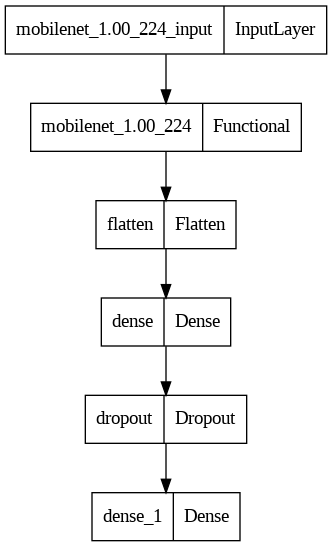

In [20]:
# Plot the Mobile Net
plot_model(MNet_model)

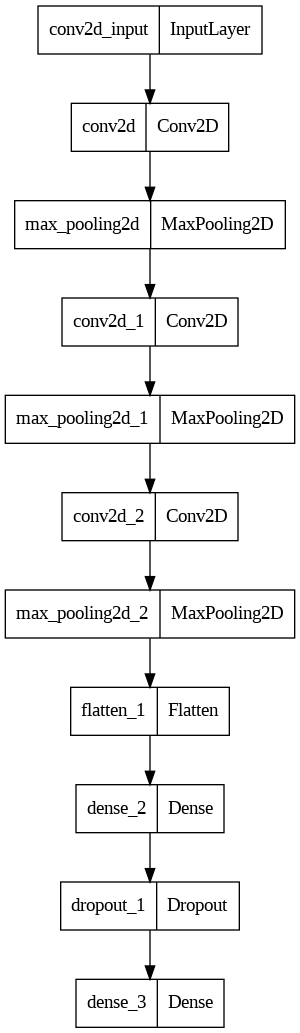

In [21]:
###Plot the Generic model
plot_model(Conv_Gen_model)

#### Model Summaries

In [22]:
# `num_classes` will hold the total number of classes.
num_classes = len(class_names)

# Initialize a Sequential model.
model1 = models.Sequential()

# Add the pre-trained VGG16 model as the base of your model.
# This includes all the convolutional layers of VGG16, pre-trained on ImageNet.
model1.add(VGG_model)

# Flatten the output of the VGG16 model because dense layers expect 1D inputs.
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dropout(0.5)) # Add a Dropout layer to prevent overfitting
# Final Dense layer for classification. The number of neurons equals the number of classes,
# with a softmax activation function to output probabilities for each class.
model1.add(layers.Dense(num_classes, activation='softmax'))

In [23]:
# Do same for the Mobile Net model
num_classes = len(class_names)

# Initialize a Sequential model
model2 = models.Sequential()

# Load the MobileNet model, pre-trained on ImageNet
MNet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add the pre-trained MobileNet model as the base of your new model
model2.add(MNet_model)

# Add the rest of the layers
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.5)) # Dropout to prevent overfitting
model2.add(layers.Dense(num_classes, activation='softmax')) # Final classification layer

###Displaying the architecture of the models :

In [24]:
# Displaying the VGG model's architecture.
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 16813638 (64.14 MB)
Trainable params: 2098950 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [33]:
# Displaying the Mobile Net model's architecture.
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               12845312  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 16075718 (61.32 MB)
Trainable params: 16053830 (61.24 MB)
Non-trainable params: 21888 (85.50 KB)
_________

In [26]:
# Displaying the Conv_Gen Model's architecture.
Conv_Gen_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)       

### Compile and train the models

In [27]:
# Compiling and training the VGG16, model 1
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [28]:
# Train the VGG16
history_VGG = model1.fit(train_images, train_labels_encoded , epochs=15,
                    validation_data=(test_images, test_labels_encoded))

Epoch 1/15
439/439 [==============================] - 15s 23ms/step - loss: 0.5596 - accuracy: 0.7958 - val_loss: 0.3803 - val_accuracy: 0.8598
Epoch 2/15
439/439 [==============================] - 8s 19ms/step - loss: 0.4170 - accuracy: 0.8449 - val_loss: 0.3578 - val_accuracy: 0.8651
Epoch 3/15
439/439 [==============================] - 8s 19ms/step - loss: 0.3666 - accuracy: 0.8665 - val_loss: 0.3383 - val_accuracy: 0.8731
Epoch 4/15
439/439 [==============================] - 8s 19ms/step - loss: 0.3317 - accuracy: 0.8775 - val_loss: 0.3451 - val_accuracy: 0.8711
Epoch 5/15
439/439 [==============================] - 8s 19ms/step - loss: 0.3128 - accuracy: 0.8854 - val_loss: 0.3427 - val_accuracy: 0.8767
Epoch 6/15
439/439 [==============================] - 8s 19ms/step - loss: 0.2946 - accuracy: 0.8904 - val_loss: 0.3239 - val_accuracy: 0.8857
Epoch 7/15
439/439 [==============================] - 8s 19ms/step - loss: 0.2742 - accuracy: 0.8963 - val_loss: 0.3592 - val_accuracy: 0.874

In [1]:
# Compiling and training the MobileNet, model2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

# Create an instance of ImageDataGenerator for training and testing data
# Apply preprocessing required for MobileNet
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


NameError: name 'train_directory' is not defined

In [35]:
# Train the model using the train generator
history_MNet = model2.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_steps=test_generator.n // test_generator.batch_size
)

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-35-31ed4fcbd7d9>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,6] and labels shape [192]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_55854]

In [ ]:
# Compile and train the Generic_Model
history_Conv_Gen = Conv_Gen_model.fit(train_images, train_labels_encoded , epochs=15,
                    validation_data=(test_images, test_labels_encoded))

### Evaluate the models

In [ ]:
# Plot training & validation accuracy values for the VGG16
plt.plot(history_VGG.history['accuracy'], label='VGG16')
plt.plot(history_VGG.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('VGG Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])  # Adjust the y-axis limits as needed
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Plot training & validation accuracy values for the MobileNet
plt.plot(history_MNet.history['accuracy'], label='MobileNet')
plt.plot(history_MNet.history['val_accuracy'], label='MobileNet Validation Accuracy')
plt.title('MobileNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])  # Adjust the y-axis limits as needed
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot training & validation accuracy values for the Conv_Gen
plt.plot(history_Conv_Gen.history['accuracy'], label='Conv_Gen')
plt.plot(history_Conv_Gen.history['val_accuracy'], label='Conv_Gen Validation Accuracy')
plt.title('Conv_Gen Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])  # Adjust the y-axis limits as needed
plt.legend(loc='lower right')
plt.show()

In [ ]:
## Calculate loss and accuracy scores for the three models
# VGG
test_loss_VG, test_acc_VG = model1.evaluate(test_images,  test_labels_encoded, verbose=2)

#MobileNet,using the test generator
test_loss_MNet, test_acc_MNet = model2.evaluate(test_generator, verbose=2)

#Conv_Gen
test_loss_Conv, test_acc_Conv = Conv_Gen_model.evaluate(test_images,  test_labels_encoded, verbose=2)

In [ ]:
# Convert numerical labels back to class names
VG_predicted_labels = [index_to_class[index] for index in VG_predicted_labels]
MNet_predicted_labels = [index_to_class[index] for index in MNet_predicted_labels]
CG_predicted_labels = [index_to_class[index] for index in CG_predicted_labels]


###Generate the confusion matrix for the three models

In [ ]:
# Generate the confusion matrix for the VG16
VG_conf_matrix = confusion_matrix(test_labels, VG_predicted_labels)

# Plot the confusion matrix using a heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(VG_conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[index_to_label[i] for i in range(len(index_to_label))],
            yticklabels=[index_to_label[i] for i in range(len(index_to_label))])
plt.title('Confusion Matrix for VGModel')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
# Generate the confusion matrix for the Mobile Net
MNet_conf_matrix = confusion_matrix(test_labels, MNet_predicted_labels)

# Plot the confusion matrix using a heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(MNet_conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[index_to_label[i] for i in range(len(index_to_label))],
            yticklabels=[index_to_label[i] for i in range(len(index_to_label))])
plt.title('Confusion Matrix for MobileNet Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [ ]:
# Generate the confusion matrix for the Conv_Gen Model
CG_conf_matrix = confusion_matrix(test_labels, CG_predicted_labels)

# Plot the confusion matrix using a heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(CG_conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[index_to_label[i] for i in range(len(index_to_label))],
            yticklabels=[index_to_label[i] for i in range(len(index_to_label))])
plt.title('Confusion Matrix for Convolution Generic Model')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

###Calculate and plot Sensitivity and Specificity for the three models

In [ ]:
# Calculate sensitivity and specificity for the three models for each class
sensitivity_VG, specificity_VG = calculate_metrics(VG_conf_matrix)
sensitivity_MNet, specificity_MNet = calculate_metrics(MNet_conf_matrix)
sensitivity_CG, specificity_CG = calculate_metrics(CG_conf_matrix)

print(sensitivity_VG, specificity_VG)


In [ ]:
def plot_combined_metrics(sensitivities, specificities, class_labels, models):
    x = np.arange(len(class_labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(14, 8))

    for i, model in enumerate(models):
        sens_bars = ax.bar(x - width + i*width, sensitivities[i], width, label=f'{model} Sensitivity')
        spec_bars = ax.bar(x + i*width, specificities[i], width, label=f'{model} Specificity')

    ax.set_xlabel('Class')
    ax.set_ylabel('Metrics')
    ax.set_title('Sensitivity and Specificity by Model and Class')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels, rotation=45, ha="right")
    ax.legend()

    plt.show()

# Assuming class_labels is a list of class names
class_labels = [index_to_label[i] for i in range(len(index_to_label))]

# Combine sensitivities and specificities for plotting
sensitivities = [sensitivity_VG, sensitivity_MNet, sensitivity_CG]
specificities = [specificity_VG, specificity_MNet, specificity_CG]
models = ['VG', 'MNet', 'CG']

plot_combined_metrics(sensitivities, specificities, class_labels, models)
